In [1]:
from Bio import SeqIO
from Bio.Seq import Seq
import gzip
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns

data_dir = '/lustre/scratch/kiviaho/dbitseq_atac/fastqs/'
filename = 'sample_A_R2_untrimmed_001.fastq.gz'
output_file = "sample_A_R2_001.fastq.gz"

index1_start = 15  # 15bp spacer
index1_end = index1_start + 10  # 10bp spatial barcode 1
index2_start = index1_end + 30  # 30bp spacer 
index2_end = index2_start + 10  # 10bp spatial barcode 2

def extract_spatial_barcode(seq_record):
    seq_record1 = seq_record[index1_start:index1_end]
    seq_record2 = seq_record[index2_start:index2_end]
    return seq_record1 + seq_record2

def count_rows_in_fastq_gz(file_path):
    with gzip.open(file_path, 'rt') as file:
        row_count = sum(1 for _ in file)
    return int(row_count/4) # 4 rows per sequence in a fastq file


def match_sequence(main_string, substring):
    # Find the starting index of the substring in the main string
    start_index = main_string.find(substring)
    
    if start_index != -1:
        # Create a string with spaces to align the substring with the main string
        aligned_substring = ' ' * start_index + substring
        
        # Print the main string and the aligned substring
        print(main_string)
        print(aligned_substring)



In [37]:
barcode_reference = pd.read_csv('spatial_location_barcodes.csv')
barcode_reference

,Sample_ID,index
0,A1_B1,ACTGGTAGGAGTAAGGCCGA
1,A1_B2,ACTGGTAGGAACGGACCTGC
2,A1_B3,ACTGGTAGGATTGGAACTGG
3,A1_B4,ACTGGTAGGAAAGGTTAAGT
4,A1_B5,ACTGGTAGGATTAGCGGTTG
...,...,...
895,A30_B26,ACGGACCTGCAGTCGCGTCG
896,A30_B27,ACGGACCTGCGTTCCGTATC
897,A30_B28,ACGGACCTGCGCTATGCGAT
898,A30_B29,ACGGACCTGCAGCTTAGGAG


In [62]:
barcodes = pd.read_csv('index_only.txt',header=None).rename(columns={0:'index'})

# 16bp clipped barcodes
#sequences = barcodes['index'].tolist()

# 20bp full-length barcodes
sequences = barcode_reference['index'].tolist()

In [63]:
# Function to calculate Hamming distance between two sequences
def hamming_distance(seq1, seq2):
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

# Initialize a matrix to store the Hamming distances
distance_matrix = np.zeros((len(sequences), len(sequences)), dtype=int)

# Calculate the Hamming distance for each pair of sequences
for i in range(len(sequences)):
    for j in range(len(sequences)):
        distance_matrix[i, j] = hamming_distance(sequences[i], sequences[j])

hamming_distances_list = distance_matrix[np.triu_indices(len(distance_matrix),k=1)]

# Print the resulting distance matrix
print(distance_matrix)

[[ 0  8  7 ... 12 16 13]
 [ 8  0  4 ... 14 15 14]
 [ 7  4  0 ... 15 14 14]
 ...
 [12 14 15 ...  0  7  6]
 [16 15 14 ...  7  0  7]
 [13 14 14 ...  6  7  0]]


Text(0.5, 0, 'Hamming distance (20bp)')

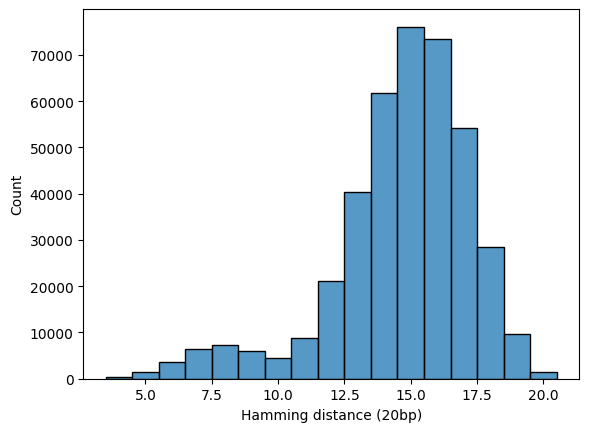

In [64]:
from matplotlib import pyplot as plt
sns.histplot(hamming_distances_list,
    binwidth=1,
    discrete=True,
    log=False,
    )
plt.xlabel('Hamming distance (20bp)')

In [55]:
900*899/2

404550.0

In [54]:
len(hamming_distances_list)

404550

In [52]:
print('{:.2%}'.format(len([i for i in hamming_distances_list if i <3])/len(hamming_distances_list)))

0.02%


In [82]:

raw_barcodes = pd.read_excel('dbitseq_atac_demo_raw_barcodes.xlsx')
bc1_list = [bc[15:25] for bc in raw_barcodes['Barcode 1']]
bc2_list = [bc[24:34] for bc in raw_barcodes['Barcode 2']]

print(f'Barcode 1: {bc1_list[:5]}')
print(f'Barcode 2: {bc2_list[:5]}')

print(f'n unique Barcode 1: {len(set(bc1_list))}')
print(f'n unique Barcode 2: {len(set(bc2_list))}')
print(f'Total intersect (all 30): {len(set(bc1_list).intersection(set(bc2_list)))}')

Barcode 1: ['TCCTACCAGT', 'GCGTTGGAGC', 'GATCTTACGC', 'CTGATGGTCA', 'CCGAGAATCC']
Barcode 2: ['TCGGCCTTAC', 'GCAGGTCCGT', 'CCAGTTCCAA', 'ACTTAACCTT', 'CAACCGCTAA']
n unique Barcode 1: 30
n unique Barcode 2: 30
Total intersect (all 30): 5


In [57]:
def reverse_complement(sequence):
    # Define the complement mapping
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}

    # Generate the complement sequence
    complement_sequence = ''.join(complement[base] for base in sequence)

    # Reverse the complement sequence
    rc_sequence = complement_sequence[::-1]
    
    return rc_sequence

In [74]:
# A sanity check to see if the read library matches the sequences

# An example read
read = 'TCGGACGATCATGGGAGGCAGTACCCAAGTATGCAGCGCGCGAAACATCGGCCACGAGCTCAGCC'

# Barcode seq 1
seq1 = 'CGCGCTGCATACTTGTCCTACCAGTCCCATGATCGTCCGA'
# Barcode seq 2
seq2 = 'CAAGCAGAAGACGGCATACGAGATTCGGCCTTACGTGGCCGATGTTTCG'

# Print the read + barcode sequences. Spacers should match, not necessarily the  unique barcodes
print(read)
print(reverse_complement(seq2 + seq1))
print(reverse_complement(seq1) + reverse_complement(seq2))

TCGGACGATCATGGGAGGCAGTACCCAAGTATGCAGCGCGCGAAACATCGGCCACGAGCTCAGCC
TCGGACGATCATGGGACTGGTAGGACAAGTATGCAGCGCGCGAAACATCGGCCACGTAAGGCCGAATCTCGTATGCCGTCTTCTGCTTG
TCGGACGATCATGGGACTGGTAGGACAAGTATGCAGCGCGCGAAACATCGGCCACGTAAGGCCGAATCTCGTATGCCGTCTTCTGCTTG


In [75]:
# A sanity check if necessary

# Read a number of reads in as string
all_reads = []
limit = 1e6 # 11084448 <-- The total number of sequences in the library
i = 0

with gzip.open(data_dir + filename, "rt") as index_file:
    # Initialize tqdm with the total number of iterations if known
    for record in tqdm(SeqIO.parse(index_file, "fastq"), total=limit):
        # Extract the two indexes from the index read
        all_reads.append(str(record.seq))
        if i > limit:
            break
        i += 1



1000001it [00:14, 67846.89it/s]                              


In [105]:

# Take a random sample (e.g. 1000)
n_total = 50000
n_correct = 0  
i=0

reads = pd.Series(all_reads).sample(n=n_total).tolist()

with gzip.open(data_dir + filename, "rt") as index_file:
    for read in tqdm(reads):
        # Extract the two indexes from the index read
        index1, index2 = extract_indices(read)
        concat_index = index1 + index2 
        if any(concat_index in index for index in barcode_reference['index']):
            n_correct +=1
        i +=1
        if i > n_total:
            break

print('Total barcode match rate is {:.2%}'.format(n_correct/n_total))

100%|██████████| 50000/50000 [00:05<00:00, 8980.88it/s]

Total barcode match rate is 57.96%


In [104]:

# Iterate through the reads to check where the barcodes match
for read in reads:
    for bc1 in barcode_reference['bc1'].unique():
        if bc1 in read:
            print('Barcode 1 match:')
            match_sequence(read, bc1)
            #print('')
    for bc2 in barcode_reference['bc2'].unique():
        if bc2 in read:
            print('Barcode 2 match:')
            match_sequence(read, bc2)
            print('')

Barcode 1 match:
TCGGACGATCATGGGTCGTTGCGGCCAAGTATGCAGCGCGCGAAACATCGGCCACTATTACTCTA
               TCGTTGCGGC
Barcode 1 match:
TCGGACGATCATGGGTCGTTGCGGCCAAGTATGCAGCGCGCGAAACATCGGCCACTATTACTCTA
                                                       TATTACTCTA
Barcode 2 match:
TCGGACGATCATGGGTCGTTGCGGCCAAGTATGCAGCGCGCGAAACATCGGCCACTATTACTCTA
                                                       TATTACTCTA

Barcode 2 match:
TCGGACGATCATGGGGGAGATGGCCAAGTATGCAGCGCGCGAAACATCGGCCACCCGGCGTTCGA
                                                      CCGGCGTTCG

Barcode 1 match:
TCGGACGATCATGGGTGGCTGACCACAAGTATGCAGCGCGCGAAACATCGGCCACCCGGCGTTCG
               TGGCTGACCA
Barcode 2 match:
TCGGACGATCATGGGTGGCTGACCACAAGTATGCAGCGCGCGAAACATCGGCCACCCGGCGTTCG
                                                       CCGGCGTTCG

Barcode 1 match:
TCGGACGATCATGGGATCCGGATAACAAGTATGCAGCGCGCGAAACATCGGCCACTGCTCCTTAT
               ATCCGGATAA
Barcode 2 match:
TCGGACGATCATGGGATCCGGATAACAAGTATGCAGCGCGCGAAACATCGGCCACTGC

In [ ]:

# Iterate through the reads to check where the barcodes match
for read in reads:
    for bc1 in [reverse_complement(b) for b in bc1_list]:
        if bc1 in read:
            print('Barcode 1 match:')
            match_sequence(read, bc1)
            #print('')
    for bc2 in [reverse_complement(b) for b in bc2_list]:
        if bc2 in read:
            print('Barcode 2 match:')
            match_sequence(read, bc2)
            print('')